In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Robust path finding for data.mat
current_path = Path.cwd()
possible_data_paths = [
    current_path / 'data' / 'data.mat',
    current_path.parent / 'data' / 'data.mat',
    current_path.parent.parent / 'data' / 'data.mat',
    # Fallback absolute path
    Path('/home/luky/skola/KalmanNet-for-state-estimation/data/data.mat')
]

dataset_path = None
for p in possible_data_paths:
    if p.exists():
        dataset_path = p
        break

if dataset_path is None or not dataset_path.exists():
    print("Warning: data.mat not found automatically.")
    dataset_path = Path('data/data.mat')

print(f"Dataset path: {dataset_path}")

# Add project root to sys.path (2 levels up from debug/test)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root added: {project_root}")

mat_data = loadmat(dataset_path)
print(mat_data.keys())


Dataset path: /home/luky/skola/KalmanNet-main/data/data.mat
Project root added: /home/luky/skola/KalmanNet-main
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Dimensions of 1D X axis: {x_axis_unique.shape}")
print(f"Dimensions of 1D Y axis: {y_axis_unique.shape}")
print(f"Dimensions of 2D elevation data Z: {souradniceZ_mapa.shape}")

terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

def terMap(px, py):
    # Query bilinear interpolation over the terrain map
    points_to_query = np.column_stack((py, px))
    return terMap_interpolator(points_to_query)

Dimensions of 1D X axis: (2500,)
Dimensions of 1D Y axis: (2500,)
Dimensions of 2D elevation data Z: (2500, 2500)


In [4]:
import torch
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 9.057863

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[5.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
# initial_velocity_np = torch.from_numpy()
initial_velocity = torch.from_numpy(np.array([0,0]))

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

tensor([1487547.1250, 6395520.5000,       0.0000,       0.0000])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils
import torch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [6]:
from state_NN_models import TAN

state_knet2 = TAN.StateKalmanNetTAN(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=12,       
        output_layer_multiplier=4,
        num_gru_layers=1,
        gru_hidden_dim_multiplier=4      
).to(device)

state_bkn = TAN.StateBayesianKalmanNetTAN(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=12,       
        output_layer_multiplier=4,
        num_gru_layers=1,
        init_max_dropout=0.2,
        init_min_dropout=0.1    
).to(device)

import os
import torch

# ==========================================
# 1. NASTAVENÍ NÁZVŮ SOUBORŮ (Manuální vstup)
# ==========================================
# Složka, kde jsou váhy uloženy
WEIGHTS_DIR = 'weights'

# Zde doplň přesné názvy souborů .pth
# KNET_FILENAME = 'best_Knet_test_results.pth'                                          # Příklad
KNET_FILENAME = 'knet_curriculum_model_vyrovnane_s_UKF.pth' #best_MSE_KalmanNet_linear_trajectory
BKN_FILENAME = 'best_mse_and_anees_bknet.pth'  

# ==========================================
# 2. FUNKCE PRO BEZPEČNÉ NAČTENÍ
# ==========================================
def load_pretrained_weights(model, filename, model_name):
    filepath = os.path.join(WEIGHTS_DIR, filename)
    
    if not os.path.exists(filepath):
        print(f"⚠️  VAROVÁNÍ: Soubor '{filename}' pro {model_name} nebyl nalezen v '{WEIGHTS_DIR}'.")
        return

    try:
        # Načtení na správné zařízení (CPU/GPU)
        checkpoint = torch.load(filepath, map_location=device)
        
        # Detekce, zda jde o čistý state_dict nebo slovník checkpointu
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Pokud je to checkpoint z traineru, vytáhneme jen váhy modelu
            state_dict = checkpoint['model_state_dict']
        elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            # Předpokládáme, že je to přímo state_dict
            state_dict = checkpoint

        # Nahrání vah do modelu
        model.load_state_dict(state_dict)
        
        # Důležité: Přepnutí do evaluačního módu (vypne Dropout, fixuje BatchNorm)
        model.eval()
        
        print(f"✅ {model_name}: Váhy úspěšně načteny z '{filename}'.")
        
    except Exception as e:
        print(f"❌ CHYBA: Nepodařilo se načíst váhy pro {model_name}.\n   Důvod: {e}")

# ==========================================
# 3. SPUŠTĚNÍ NAČÍTÁNÍ
# ==========================================
print(f"--- Načítání vah ze složky: {os.path.abspath(WEIGHTS_DIR)} ---\n")

# Načtení State KalmanNet
load_pretrained_weights(state_knet2, KNET_FILENAME, "State KalmanNet")

# Načtení Bayesian KalmanNet
load_pretrained_weights(state_bkn, BKN_FILENAME, "State BKN")

print("\n--- Hotovo ---")

DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
INFO: Aplikuji upravenou inicializaci pro BKN.
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.1 až 0.1).
--- Načítání vah ze složky: /home/luky/skola/KalmanNet-main/TAN/synthetic_data_only/weights ---

✅ State KalmanNet: Váhy úspěšně načteny z 'knet_curriculum_model_vyrovnane_s_UKF.pth'.
✅ State BKN: Váhy úspěšně načteny z 'best_mse_and_anees_bknet.pth'.

--- Hotovo ---


# Test na synteticke trajektorii

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Filters
import os
from tqdm import tqdm

# === KONFIGURACE ===
TEST_DATA_PATH = './generated_data_synthetic_controlled/test_set/test.pt'
PLOT_PER_ITERATION = True  # Vykreslovat graf pro každou trajektorii?
MAX_TEST_SAMPLES = 20      # Kolik trajektorií z test setu vyhodnotit (max 10, co jsme vygenerovali)
J_EVALUATION = 100           # Počet Monte Carlo vzorků pro BKN (Ensemble size)
print(f"=== VYHODNOCENÍ NA TESTOVACÍ SADĚ ===")
print(f"Načítám data z: {TEST_DATA_PATH}")

# 1. Načtení Testovací sady
if not os.path.exists(TEST_DATA_PATH):
    raise FileNotFoundError(f"Soubor {TEST_DATA_PATH} neexistuje! Spusťte generování testovací sady.")

test_data = torch.load(TEST_DATA_PATH, map_location=device)
X_test_all = test_data['x']  # Ground Truth [N, Seq, 4]
Y_test_all = test_data['y']  # Measurements [N, Seq, 3]

n_samples = min(X_test_all.shape[0], MAX_TEST_SAMPLES)
print(f"Počet testovacích trajektorií: {n_samples}")
print(f"Délka sekvence: {X_test_all.shape[1]}")
print("Modely: KalmanNet vs. UKF vs. PF vs. BKN")

# 2. Inicializace pro sběr dat
detailed_results = []
agg_mse = {"KNet": [], "UKF": [], "PF": [], "BKN": []}
agg_pos = {"KNet": [], "UKF": [], "PF": [], "BKN": []}
agg_anees = {"UKF": [], "PF": [], "BKN": []}
# Ujistíme se, že KNet je v eval módu
state_knet2.eval()
state_bkn.eval()
# --- POMOCNÁ FUNKCE PRO ANEES ---
def calculate_anees(gt, est, P):
    """
    Vypočítá Average Normalized Estimation Error Squared.
    gt: Ground Truth [T, Dim] (NumPy)
    est: Odhad [T, Dim] (NumPy)
    P: Kovarianční matice [T, Dim, Dim] (NumPy)
    """
    T = min(len(gt), len(est), len(P))
    anees_vals = []
    
    # Oříznutí na stejnou délku
    gt = gt[:T]
    est = est[:T]
    P = P[:T]
    
    for t in range(T):
        e_t = gt[t] - est[t] # Chyba v čase t
        P_t = P[t]
        
        try:
            # Inverze kovariance
            # Přičteme malé epsilon na diagonálu pro numerickou stabilitu, pokud je singulární
            if np.linalg.cond(P_t) > 1e10:
                P_t = P_t + np.eye(P_t.shape[0]) * 1e-6
                
            P_inv = np.linalg.inv(P_t)
            
            # Mahalanobisova vzdálenost: e^T * P^-1 * e
            anees_t = e_t.T @ P_inv @ e_t
            anees_vals.append(anees_t)
        except np.linalg.LinAlgError:
            anees_vals.append(np.nan)
            
    return np.nanmean(anees_vals)
from tqdm import tqdm
# --- HLAVNÍ SMYČKA (Iterace přes testovací trajektorie) ---
for i in tqdm(range(n_samples),desc="Evaluating trajectories"):
    
    # A) Příprava dat pro tento běh
    x_gt_tensor = X_test_all[i]      # [Seq, 4]
    y_obs_tensor = Y_test_all[i]     # [Seq, 3]
    
    x_gt = x_gt_tensor.cpu().numpy()
    seq_len = x_gt.shape[0]
    
    # Skutečný startovní stav (pro inicializaci filtrů)
    true_init_state = x_gt_tensor[0] # [4]
    
    # B) Inference: KalmanNet
    # KNet očekává [Batch, Seq, Dim], takže musíme přidat dimenzi
    with torch.no_grad():
        initial_state_batch = true_init_state.unsqueeze(0) # [1, 4]
        
        # Reset stavu sítě
        state_knet2.reset(batch_size=1, initial_state=initial_state_batch)
        
        knet_preds = []
        # KNet zpracovává sekvenci krok po kroku (nebo bychom mohli upravit forward na celou sekvenci)
        # Zde zachováme logiku step-by-step pro konzistenci
        
        # Vstup y_obs_tensor má tvar [Seq, 3]. Potřebujeme [1, 3] pro každý krok
        y_input_batch = y_obs_tensor.unsqueeze(0) # [1, Seq, 3]
        
        for t in range(1, seq_len):
            y_t = y_input_batch[:, t, :] # [1, 3]
            x_est = state_knet2.step(y_t)
            knet_preds.append(x_est)
            
        # Složení predikce (přidáme počáteční stav)
        if len(knet_preds) > 0:
            knet_preds_tensor = torch.stack(knet_preds, dim=1) # [1, Seq-1, 4]
            full_knet_est = torch.cat([initial_state_batch.unsqueeze(1), knet_preds_tensor], dim=1)
        else:
            full_knet_est = initial_state_batch.unsqueeze(1)
            
        x_est_knet = full_knet_est.squeeze().cpu().numpy()

        # --- B) BKN (Ensemble) ---
    with torch.no_grad():
        init_batch = true_init_state.unsqueeze(0).repeat(J_EVALUATION, 1)
        state_bkn.reset(batch_size=J_EVALUATION, initial_state=init_batch)
        
        bkn_preds = []
        y_input_batch = y_obs_tensor.unsqueeze(0).repeat(J_EVALUATION, 1, 1)
        
        for t in range(1, seq_len):
            y_t = y_input_batch[:, t, :]
            x_est, _ = state_bkn.step(y_t) 
            bkn_preds.append(x_est)
            
        if len(bkn_preds) > 0:
            bkn_preds_tensor = torch.stack(bkn_preds, dim=1) # [J, Seq-1, 4]
            full_bkn_ensemble = torch.cat([init_batch.unsqueeze(1), bkn_preds_tensor], dim=1) # [J, Seq, 4]
            
            # Mean Estimate
            x_est_mean = full_bkn_ensemble.mean(dim=0)
            x_est_bkn = x_est_mean.cpu().numpy()
            
            # --- VÝPOČET KOVARIANCE PRO BKN ---
            # P = 1/(J-1) * sum((x_j - x_mean) * (x_j - x_mean)^T)
            # Vycentrování
            residuals = full_bkn_ensemble - x_est_mean.unsqueeze(0) # [J, Seq, 4]
            # Permute pro batch matmul: [Seq, J, 4] a [Seq, 4, J]
            residuals = residuals.permute(1, 2, 0) # [Seq, 4, J]
            
            # Batch matrix multiplication: (Seq, 4, J) @ (Seq, J, 4) -> (Seq, 4, 4)
            P_bkn_tensor = torch.bmm(residuals, residuals.transpose(1, 2)) / (J_EVALUATION - 1)
            # Přičtení process noise/stabilitu (volitelné, BKN variance je epistemická)
            P_bkn = P_bkn_tensor.cpu().numpy()
            
        else:
            x_est_bkn = x_gt
            P_bkn = np.eye(4)[np.newaxis, :, :].repeat(len(x_gt), axis=0)
    # C) Inference: UKF & PF
    # Filtry očekávají [Seq, Dim] (bez batch dimenze, pokud tak byly napsány)
    
    # UKF
    ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
    ukf_res = ukf_ideal.process_sequence(
        y_seq=y_obs_tensor,
        Ex0=true_init_state, 
        P0=system_model.P0
    )
    x_est_ukf = ukf_res['x_filtered'].cpu().numpy()

    # PF (Snížil jsem počet částic na 2000 pro rychlost, pro finální diplomku dejte více)
    pf = Filters.VectorizedParticleFilter(system_model, num_particles=4372281) #4372281
    pf_res = pf.process_sequence(
        y_seq=y_obs_tensor,
        Ex0=true_init_state, 
        P0=system_model.P0
    )
    x_est_pf = pf_res['x_filtered'].cpu().numpy()
    
    def calc_metrics(est, gt, P_mat):
        diff = est[:min_len] - gt[:min_len]
        mse = np.mean(np.sum(diff[:, :2]**2, axis=1)) 
        pos_err = np.mean(np.sqrt(diff[:, 0]**2 + diff[:, 1]**2))
        
        anees = np.nan
        if P_mat is not None:
            anees = calculate_anees(gt[:min_len], est[:min_len], P_mat[:min_len])
            
        return mse, pos_err, anees
    
    # D) Výpočet chyb
    # Ořežeme na délku min(odhad, gt) pro jistotu
    min_len = min(len(x_gt), len(x_est_knet), len(x_est_ukf))
    
    # KNet
    diff_knet = x_est_knet[:min_len] - x_gt[:min_len]
    mse_knet = np.mean(np.sum(diff_knet[:, :2]**2, axis=1)) # Pouze XY chyba
    pos_err_knet = np.mean(np.sqrt(diff_knet[:, 0]**2 + diff_knet[:, 1]**2))
    
    #BKN
    diff_bkn = x_est_bkn[:min_len] - x_gt[:min_len]
    mse_bkn = np.mean(np.sum(diff_bkn[:, :2]**2, axis=1)) # Pouze XY chyba
    pos_err_bkn = np.mean(np.sqrt(diff_bkn[:, 0]**2 + diff_bkn[:, 1]**2))
    anees_bkn = calculate_anees(x_gt[:min_len], x_est_bkn[:min_len], P_bkn[:min_len])
    # UKF
    diff_ukf = x_est_ukf[:min_len] - x_gt[:min_len]
    mse_ukf = np.mean(np.sum(diff_ukf[:, :2]**2, axis=1))
    pos_err_ukf = np.mean(np.sqrt(diff_ukf[:, 0]**2 + diff_ukf[:, 1]**2))
    
    # PF
    diff_pf = x_est_pf[:min_len] - x_gt[:min_len]
    mse_pf = np.mean(np.sum(diff_pf[:, :2]**2, axis=1))
    pos_err_pf = np.mean(np.sqrt(diff_pf[:, 0]**2 + diff_pf[:, 1]**2))
    
    # Uložení
    agg_mse["KNet"].append(mse_knet)
    agg_pos["KNet"].append(pos_err_knet)
    agg_mse["BKN"].append(mse_bkn)
    agg_pos["BKN"].append(pos_err_bkn)
    agg_mse["UKF"].append(mse_ukf)
    agg_pos["UKF"].append(pos_err_ukf)
    agg_mse["PF"].append(mse_pf)
    agg_pos["PF"].append(pos_err_pf)

    detailed_results.append({
        "Run_ID": i + 1,
        "KNet_MSE": mse_knet,
        "BKN_MSE": mse_bkn,
        "UKF_MSE": mse_ukf,
        "PF_MSE": mse_pf,
        "KNet_PosErr": pos_err_knet,
        "BKN_PosErr": pos_err_bkn,
        "UKF_PosErr": pos_err_ukf,
        "PF_PosErr": pos_err_pf
    })
    
    # E) Vykreslení
    if PLOT_PER_ITERATION or (i == n_samples - 1):
        fig = plt.figure(figsize=(12, 6))
        # Vykreslíme jen XY trajektorii
        plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='Ground Truth')
        plt.plot(x_est_knet[:, 0], x_est_knet[:, 1], 'g-', linewidth=2, label=f'KalmanNet (Err: {pos_err_knet:.1f}m)')
        plt.plot(x_est_bkn[:, 0], x_est_bkn[:, 1], 'm-', linewidth=2, label=f'BKN (Err: {pos_err_bkn:.1f}m)')
        plt.plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (Err: {pos_err_ukf:.1f}m)')
        plt.plot(x_est_pf[:, 0], x_est_pf[:, 1], 'r:', linewidth=1, alpha=0.6, label=f'PF (Err: {pos_err_pf:.1f}m)')
        
        plt.title(f"Test Trajectory {i+1} (Length {seq_len})")
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# --- VÝPIS VÝSLEDKŮ ---
df_results = pd.DataFrame(detailed_results)
print("\n" + "="*80)
print(f"DETAILNÍ VÝSLEDKY PO JEDNOTLIVÝCH TRAJEKTORIÍCH")
print("="*80)
pd.options.display.float_format = '{:,.2f}'.format
print(df_results[["Run_ID", "KNet_MSE", "BKN_MSE", "UKF_MSE", "PF_MSE", "KNet_PosErr", "BKN_PosErr", "UKF_PosErr", "PF_PosErr"]])

print("\n" + "="*80)
print(f"SOUHRNNÁ STATISTIKA ({n_samples} trajektorií)")
print("="*80)

def get_stats(key):
    return np.mean(agg_mse[key]), np.std(agg_mse[key]), np.mean(agg_pos[key]), np.std(agg_pos[key])

knet_stats = get_stats("KNet")
bkn_stats = get_stats("BKN")
ukf_stats = get_stats("UKF")
pf_stats = get_stats("PF")

print(f"{'Model':<15} | {'MSE (Mean ± Std)':<25} | {'Pos Error (Mean ± Std)':<25}")
print("-" * 75)
print(f"{'KalmanNet':<15} | {knet_stats[0]:.1f} ± {knet_stats[1]:.1f} | {knet_stats[2]:.2f} ± {knet_stats[3]:.2f} m")
print(f"{'BKN':<15} | {bkn_stats[0]:.1f} ± {bkn_stats[1]:.1f} | {bkn_stats[2]:.2f} ± {bkn_stats[3]:.2f} m")
print(f"{'UKF':<15} | {ukf_stats[0]:.1f} ± {ukf_stats[1]:.1f} | {ukf_stats[2]:.2f} ± {ukf_stats[3]:.2f} m")
print(f"{'PF':<15} | {pf_stats[0]:.1f} ± {pf_stats[1]:.1f} | {pf_stats[2]:.2f} ± {pf_stats[3]:.2f} m")
print("="*80)

plt.figure(figsize=(10, 6))
plt.boxplot([agg_pos["KNet"], agg_pos["BKN"], agg_pos["UKF"], agg_pos["PF"]], labels=['KalmanNet', 'BKN', 'UKF', 'PF'], patch_artist=True)
plt.title(f"Position Error Distribution ({n_samples} test trajectories)")
plt.ylabel("Avg Position Error [m]")
plt.grid(True, axis='y')
plt.show()

=== VYHODNOCENÍ NA TESTOVACÍ SADĚ ===
Načítám data z: ./generated_data_synthetic_controlled/test_set/test.pt
Počet testovacích trajektorií: 20
Délka sekvence: 1000
Modely: KalmanNet vs. UKF vs. PF vs. BKN


Evaluating trajectories:   0%|          | 0/20 [00:05<?, ?it/s]


KeyboardInterrupt: 

Generuji srovnávací analýzu neurčitosti pro trajektorii č. 2...


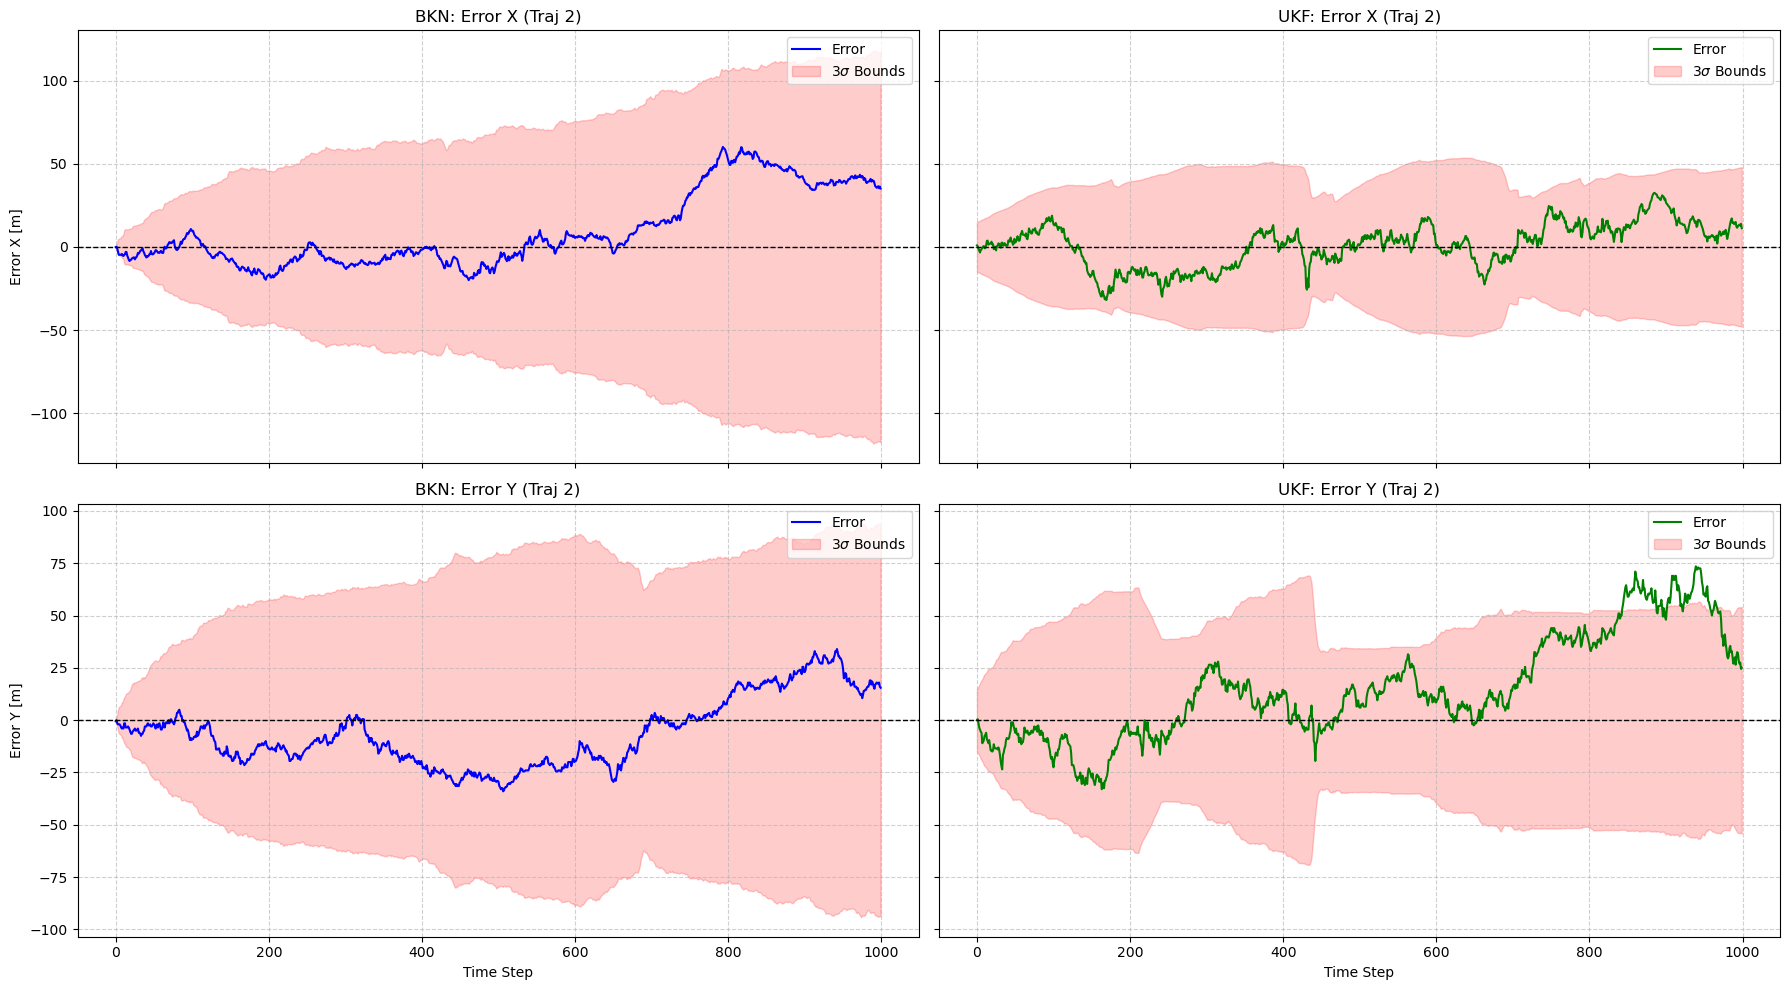

--- 3-Sigma Coverage Analysis ---
BKN Axis X: 100.00% inside 3-sigma
UKF Axis X: 100.00% inside 3-sigma
------------------------------
BKN Axis Y: 100.00% inside 3-sigma
UKF Axis Y: 89.00% inside 3-sigma


In [11]:
# === VIZUALIZACE NEURČITOSTI: BKN vs UKF ===

# Nastavení indexu trajektorie
TRAJ_IDX = 2
ZOOM_SLICE = slice(0, None) 

print(f"Generuji srovnávací analýzu neurčitosti pro trajektorii č. {TRAJ_IDX}...")

# 1. Příprava dat
x_gt_tensor = X_test_all[TRAJ_IDX].to(device)
y_obs_tensor = Y_test_all[TRAJ_IDX].to(device)
x_gt = x_gt_tensor.cpu().numpy()
seq_len = x_gt.shape[0]
true_init_state = x_gt_tensor[0]

# --- A) BKN (Ensemble Inference) ---
state_bkn.eval()
with torch.no_grad():
    init_batch = true_init_state.unsqueeze(0).repeat(J_EVALUATION, 1)
    y_input_batch = y_obs_tensor.unsqueeze(0).repeat(J_EVALUATION, 1, 1)
    state_bkn.reset(batch_size=J_EVALUATION, initial_state=init_batch)
    
    bkn_preds_steps = []
    for t in range(1, seq_len):
        x_est, _ = state_bkn.step(y_input_batch[:, t, :])
        bkn_preds_steps.append(x_est)
    
    if len(bkn_preds_steps) > 0:
        preds_tensor = torch.stack(bkn_preds_steps, dim=1)
        full_ensemble = torch.cat([init_batch.unsqueeze(1), preds_tensor], dim=1)
        
        # Mean & Covariance
        bkn_mean = full_ensemble.mean(dim=0).cpu().numpy()
        residuals = full_ensemble - full_ensemble.mean(dim=0).unsqueeze(0)
        res_perm_T = residuals.permute(1, 2, 0)
        res_perm = residuals.permute(1, 0, 2)
        bkn_P = (torch.bmm(res_perm_T, res_perm) / (J_EVALUATION - 1)).cpu().numpy()
    else:
        bkn_mean = x_gt
        bkn_P = np.zeros((seq_len, 4, 4))

# --- B) UKF (Ideal Baseline) ---
# Použijeme tu "lepší" implementaci z Filters
ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
ukf_res = ukf_ideal.process_sequence(y_obs_tensor, true_init_state, system_model.P0)

ukf_mean = ukf_res['x_filtered'].cpu().numpy()
# Zkusíme vytáhnout P, různé implementace vrací různé klíče
ukf_P = ukf_res.get('P_filtered', ukf_res.get('P', None))
if ukf_P is not None:
    ukf_P = ukf_P.cpu().numpy()
else:
    # Fallback kdyby P nebylo uloženo
    ukf_P = np.zeros((seq_len, 4, 4))

# --- C) Výpočet chyb a mezí ---
def get_stats(mean, P, gt):
    err = mean - gt
    sigma_x = np.sqrt(P[:, 0, 0])
    sigma_y = np.sqrt(P[:, 1, 1])
    return err[:, 0], err[:, 1], sigma_x, sigma_y

bkn_err_x, bkn_err_y, bkn_sig_x, bkn_sig_y = get_stats(bkn_mean, bkn_P, x_gt)
ukf_err_x, ukf_err_y, ukf_sig_x, ukf_sig_y = get_stats(ukf_mean, ukf_P, x_gt)

# --- D) Vykreslení (2x2 Grid) ---
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey='row')
time_steps = np.arange(seq_len)

# Funkce pro vykreslení jednoho subplotu
def plot_uncertainty(ax, err, sig, title, color_line):
    ax.plot(time_steps[ZOOM_SLICE], err[ZOOM_SLICE], color=color_line, label='Error')
    ax.fill_between(time_steps[ZOOM_SLICE], -3*sig[ZOOM_SLICE], 3*sig[ZOOM_SLICE], 
                    color='red', alpha=0.2, label='3$\sigma$ Bounds')
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper right')

# 1. BKN X
plot_uncertainty(axes[0, 0], bkn_err_x, bkn_sig_x, f"BKN: Error X (Traj {TRAJ_IDX})", 'blue')
axes[0, 0].set_ylabel("Error X [m]")

# 2. UKF X
plot_uncertainty(axes[0, 1], ukf_err_x, ukf_sig_x, f"UKF: Error X (Traj {TRAJ_IDX})", 'green')

# 3. BKN Y
plot_uncertainty(axes[1, 0], bkn_err_y, bkn_sig_y, f"BKN: Error Y (Traj {TRAJ_IDX})", 'blue')
axes[1, 0].set_ylabel("Error Y [m]")
axes[1, 0].set_xlabel("Time Step")

# 4. UKF Y
plot_uncertainty(axes[1, 1], ukf_err_y, ukf_sig_y, f"UKF: Error Y (Traj {TRAJ_IDX})", 'green')
axes[1, 1].set_xlabel("Time Step")

plt.tight_layout()
plt.show()

# --- E) Statistiky pokrytí ---
def print_cov(name, err, sig):
    inside = np.sum((err >= -3*sig) & (err <= 3*sig)) / len(err) * 100
    print(f"{name}: {inside:.2f}% inside 3-sigma")

print("--- 3-Sigma Coverage Analysis ---")
print_cov("BKN Axis X", bkn_err_x, bkn_sig_x)
print_cov("UKF Axis X", ukf_err_x, ukf_sig_x)
print("-" * 30)
print_cov("BKN Axis Y", bkn_err_y, bkn_sig_y)
print_cov("UKF Axis Y", ukf_err_y, ukf_sig_y)